# Multivariate time series forecasting

* Ref:
* Data: 用 statsmodels 自帶的 data

## 4 steps
* Import libraries
* Load data
* Fit model
* Make a forecast
* For example
```python
# import libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
# load data
macrodata = sm.datasets.macrodata.load_pandas().data
data = macrodata.iloc[:, 2:4]
data.tail(2)
# fit model
model = VAR(data)
model_fit = model.fit()
# make a forecast
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)
```

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display
# import statsmodels.api as sm
# 

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import statsmodels.api as sm
df = sm.datasets.macrodata.load_pandas().data
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


* 只用 realgdp 和 realcons 兩個欄位來做

In [ ]:
df  = df.iloc[:, 2:4]
df.head()

,realgdp,realcons
0,2710.349,1707.4
1,2778.801,1733.7
2,2775.488,1751.8
3,2785.204,1753.7
4,2847.699,1770.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realgdp   203 non-null    float64
 1   realcons  203 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


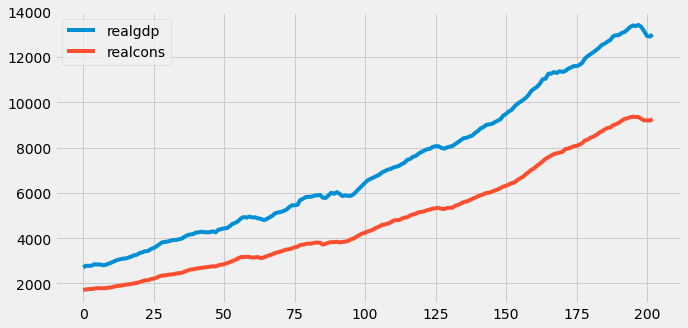

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

## 2. Analysis

### 2.1 Granger’s causality test
* 測試結果只是表示兩者之間有相關，並不能確定說一者造成另外一者
* 要怎麼讀 Granger’s causality test 的輸出？

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = grangercausalitytests(df, maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.1879  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1878  , p=0.6647  , df=1
parameter F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=47.0132 , p=0.0000  , df=2
likelihood ratio test: chi2=42.2456 , p=0.0000  , df=2
parameter F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2


{1: ({'lrtest': (0.18783818842985056, 0.6647219979749716, 1),
   'params_ftest': (0.18513457660727436, 0.6674629046854438, 199.0, 1.0),
   'ssr_chi2test': (0.18792555012301432, 0.6646488014192131, 1),
   'ssr_ftest': (0.1851345766063359, 0.6674629046862282, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (42.24557154285458, 6.706419208308308e-10, 2),
   'params_ftest': (22.921847866320157, 1.1341942621494033e-09, 196.0, 2.0),
   'ssr_chi2test': (47.013177766636595, 6.183269269576093e-11, 2),
   'ssr_ftest': (22.921847866320327, 1.1341942621492358e-09, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

## 2.2 Check for stationarity


In [ ]:
# train test split
nobs = 150
df_train = df[: nobs]
df_test = df[nobs:]

In [ ]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [ ]:
#apply adf test on the series
adf_test(df_train["realgdp"])
print('\n')
adf_test(df_train["realcons"])

Test Statistic            1.504996
p-value                   0.997543
# Lags                    2.000000
# Observations          147.000000
Critical Value (1%)      -3.475637
Critical Value (5%)      -2.881410
Critical Value (10%)     -2.577365
dtype: float64
 Series is Non-Stationary


Test Statistic            1.659313
p-value                   0.998025
# Lags                    3.000000
# Observations          146.000000
Critical Value (1%)      -3.475953
Critical Value (5%)      -2.881548
Critical Value (10%)     -2.577439
dtype: float64
 Series is Non-Stationary


* 因為都是 non-stationary 的，所以要做 differencing

In [ ]:
# 1st difference
df_differenced = df_train.diff().dropna()

# 做完 differencing 之後再檢查一次是否是 stationary 的
adf_test(df_differenced["realgdp"])
print('\n')
adf_test(df_differenced["realcons"])

Test Statistic         -5.898566e+00
p-value                 2.813225e-07
# Lags                  1.000000e+00
# Observations          1.470000e+02
Critical Value (1%)    -3.475637e+00
Critical Value (5%)    -2.881410e+00
Critical Value (10%)   -2.577365e+00
dtype: float64
 Series is Stationary


Test Statistic           -4.169482
p-value                   0.000742
# Lags                    2.000000
# Observations          146.000000
Critical Value (1%)      -3.475953
Critical Value (5%)      -2.881548
Critical Value (10%)     -2.577439
dtype: float64
 Series is Stationary


* 現在兩個 time series 都是 stationary，可以用來餵給 VAR model

## 3. Forecast
可以分成下面幾個步驟:
* model fitting 訓練模型
* forecast 預計結果
* visualization 畫圖看結果怎樣
* evaluation 評估模型好壞
* invert transformation 把結果轉回還沒有經過 differencing 時的樣子
* visualization 畫出原本的 scale 看結果怎樣

In [ ]:
# model fitting
from statsmodels.tsa.api import VAR
model = VAR(df_differenced)
model_fitted = model.fit(maxlags=15, ic='aic')
model_fitted.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Sep, 2020
Time:                     23:37:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8781
Nobs:                     146.000    HQIC:                   13.7083
Log likelihood:          -1392.55    FPE:                    799859.
AIC:                      13.5920    Det(Omega_mle):         728343.
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               6.963853         6.835170            1.019           0.308
L1.realgdp         -0.153795         0.108600           -1.416           0.157
L1.realcons         0.923430         0.178801            5.165    

In [ ]:
# forecasting
lag_order = model_fitted.k_ar
print(lag_order)

steps = len(df_test)
print(steps)

predictions = model_fitted.forecast(df_test.values, steps) # 預測跟 testing 一樣多個
print(predictions)

3
53
[[11812.81587735  5218.82568662]
 [ 8293.68354049  4326.99826188]
 [ 5927.37284124  3444.38433734]
 [ 4245.3064338   1905.27077302]
 [ 2885.69316008  1557.80108307]
 [ 2064.49518616  1177.63816463]
 [ 1499.64712141   699.78004994]
 [ 1041.9489369    573.95561111]
 [  759.12127472   423.78933334]
 [  555.39541502   271.21470789]
 [  397.1756132    223.35459953]
 [  297.47097298   166.46605303]
 [  224.70726491   117.31632002]
 [  169.96568837    99.02736846]
 [  134.82500411    78.18742462]
 [  108.97604138    62.16433402]
 [   89.99977352    55.20878622]
 [   77.59044672    47.73402444]
 [   68.44365798    42.44138409]
 [   61.84958935    39.82031782]
 [   57.46454988    37.17706505]
 [   54.2373575     35.40569599]
 [   51.94093214    34.42857644]
 [   50.39132092    33.50249817]
 [   49.25511501    32.9023307 ]
 [   48.45376382    32.54190737]
 [   47.9063449     32.21932332]
 [   47.50690998    32.01377903]
 [   47.22678758    31.88211253]
 [   47.03351708    31.77011013]
 [   

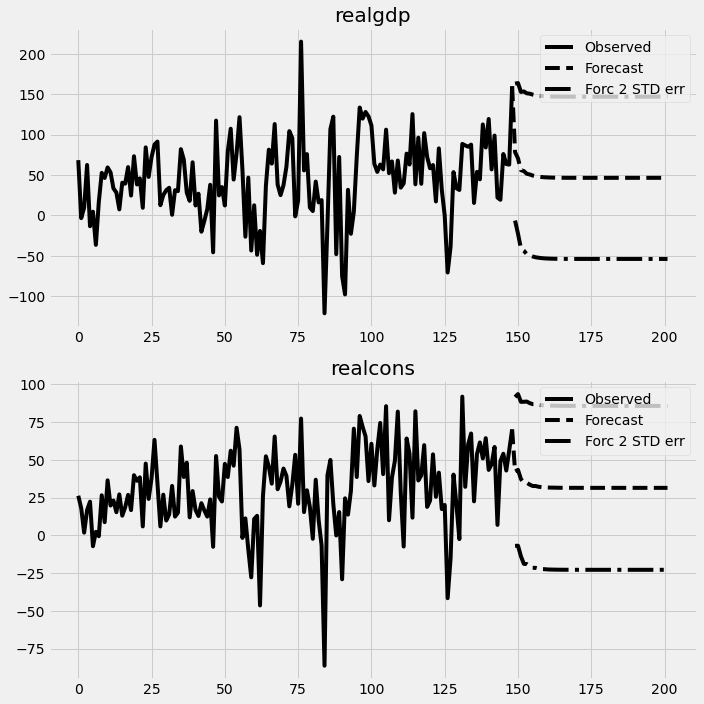

In [ ]:
# plotting
fig = model_fitted.plot_forecast(steps)
fig.tight_layout()

In [ ]:
# evaluate
# 用 Forecast Error Variance Decomposition (FEVD) method 來估計 model 的好壞
fevd = model_fitted.fevd(steps)
fevd.summary()

FEVD for realgdp
       realgdp  realcons
0     1.000000  0.000000
1     0.853113  0.146887
2     0.804191  0.195809
3     0.777014  0.222986
4     0.761258  0.238742
5     0.755489  0.244511
6     0.752854  0.247146
7     0.751142  0.248858
8     0.750490  0.249510
9     0.750150  0.249850
10    0.749947  0.250053
11    0.749865  0.250135
12    0.749822  0.250178
13    0.749798  0.250202
14    0.749788  0.250212
15    0.749782  0.250218
16    0.749779  0.250221
17    0.749778  0.250222
18    0.749778  0.250222
19    0.749777  0.250223
20    0.749777  0.250223
21    0.749777  0.250223
22    0.749777  0.250223
23    0.749777  0.250223
24    0.749777  0.250223
25    0.749777  0.250223
26    0.749777  0.250223
27    0.749777  0.250223
28    0.749777  0.250223
29    0.749777  0.250223
30    0.749777  0.250223
31    0.749777  0.250223
32    0.749777  0.250223
33    0.749777  0.250223
34    0.749777  0.250223
35    0.749777  0.250223
36    0.749777  0.250223
37    0.749777  0.250223
38    0.

In [ ]:
# invert transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    # 把所有做過 differencing 的欄位反轉，得到原本的 scale
    columns = df_train.columns
    for col in columns:
        if second_diff:
            df_forecast[str(col) + '_1d'] = (df_train.iloc[-1][col] - df_train.iloc[-2][col]) + df_forecast[str(col) + '_1d'].cumsum()
        df_forecast[str(col) + '_forecast'] = df_train.iloc[-1][col] + df_forecast[str(col) + '_1d'].cumsum()
    return df_forecast

In [ ]:
df_forecast = pd.DataFrame(predictions, index=df.index[nobs:], columns=df.columns + '_1d')
display(df_forecast.head())

df_final = invert_transformation(df_train, df_forecast)

df_final = pd.concat([df_test, df_final], axis=1)
display(df_final.head())

,realgdp_1d,realcons_1d
150,11812.815877,5218.825687
151,8293.683540,4326.998262
152,5927.372841,3444.384337
153,4245.306434,1905.270773
154,2885.693160,1557.801083


,realgdp,realcons,realgdp_1d,realcons_1d,realgdp_forecast,realcons_forecast
150,9488.879,6314.6,11812.815877,5218.825687,21219.867877,11495.925687
151,9592.458,6366.1,8293.683540,4326.998262,29513.551418,15822.923948
152,9666.235,6430.2,5927.372841,3444.384337,35440.924259,19267.308286
153,9809.551,6456.2,4245.306434,1905.270773,39686.230693,21172.579059
154,9932.672,6566.0,2885.693160,1557.801083,42571.923853,22730.380142


No handles with labels found to put in legend.


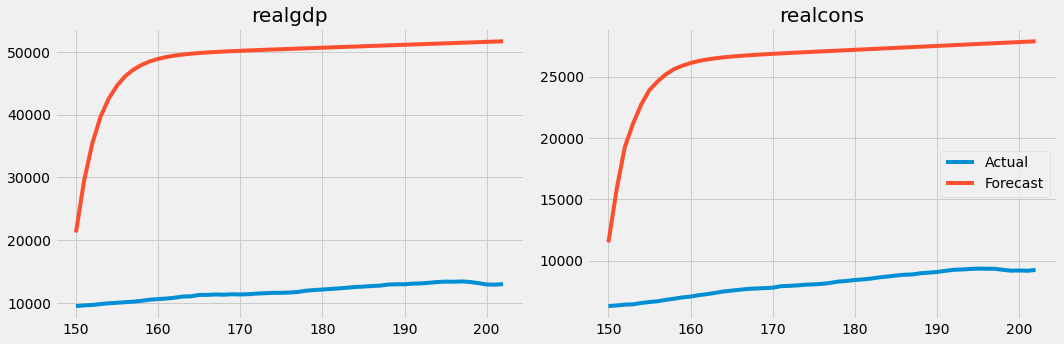

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_final['realgdp'].plot(ax=ax[0], label='Actual')
df_final['realgdp_forecast'].plot(ax=ax[0], label='Forecast')
ax[0].set_title('realgdp')
plt.legend()

df_final['realcons'].plot(ax=ax[1], label='Actual')
df_final['realcons_forecast'].plot(ax=ax[1], label='Forecast')
ax[1].set_title('realcons')
plt.legend()

plt.tight_layout()
plt.show()